<a href="https://colab.research.google.com/github/dishui78157/ai/blob/rl/Intro_RL_Session_12_13_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Build Your First AI Agent Using Reinforcement Learning

In this session we will provide a hands-on introduction to reinforcement learning. The specific agenda is as follows:
- First we will demonstrate the use of the Gymnasium (formerly OpenAI Gym) platform as a testbed for reinforcement learning.
- We will then implement and provide intuition behind the Q-learning algorithm, which is a popular technique in reinforcement learning.
- Finally we will demonstrate our implementation of Q-learning on two separate environments within Gymnasium, where the algorithm will learn to skillfully perform both tasks.

What we will not cover here:
- Details and theoretical justification behind the Q-learning algorithm.
- Other reinforcement learning algorithms aside from Q-learning.

In [1]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.1 MB/s eta 0:00:00


In [2]:
import gymnasium as gym

import time
import random
from IPython import display
import matplotlib
import matplotlib.pyplot as plt

---

In this session we will look at the [Taxi environment](https://gymnasium.farama.org/environments/toy_text/taxi/) in Gymnasium. In this environment, the goal is to navigate the taxi to the passenger, pick up the passenger, navigate to the passenger's destination, then drop off the passenger. This is achieved by performing the correct sequence of actions from among the possible actions "move up", "move down", "move left", "move right", "pick up passenger", and "drop off passenger".

In reinforcement learning, our goal is to learn a *policy* for successfully performing a task. A policy decides what *action* to take at each step based on an observation of the system's overall *state*. Each time we perform an action we receive a *reward* that is aligned with the overall objective. We will learn a policy by interacting with the system to determine which actions, when performed in each state, lead us to the higest rewards.

To get a clearer understanding of states, actions and rewards, let's look at the states we observe and rewards we receive when we take random actions in the Taxi environment.

**NOTE:** Animations are best viewed by running this notebook locally (outside of Colab).

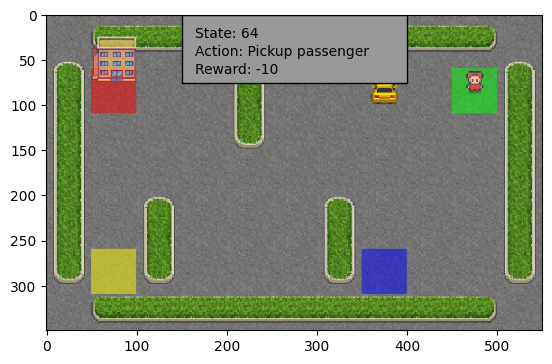

In [4]:
# Generate some descriptive names to display for the acions
action_desc = {
    0: "Move south (down)",
    1: "Move north (up)",
    2: "Move east (right)",
    3: "Move west (left)",
    4: "Pickup passenger",
    5: "Drop off passenger"
}

# Create the Taxi environment
env = gym.make("Taxi-v3", render_mode="rgb_array")

# Initilize the environment and draw the current state
obs = env.reset()[0]
plt.imshow(env.render())
plt.show()

# Loop for 100 time steps
for i in range(100):

    # Select a random action
    action = env.action_space.sample()

    # Apply the action, then observe the state and reward
    obs, reward, done, info, other = env.step(action)

    # Draw the new state
    display.clear_output(wait=True)
    plt.imshow(env.render())

    # Add a caption indicating the curent state, action, and reward
    rect = matplotlib.patches.Rectangle((150,0), 250, 75, facecolor="#999999", edgecolor="#000000")
    ax = plt.gca()
    ax.add_patch(rect)
    plt.text(165,25,f"State: {obs}")
    plt.text(165,45,f"Action: {action_desc[action]}")
    plt.text(165,65,f"Reward: {reward}")

    plt.show()

# Close the environment
env.close()

How can we learn the correct sequence of actions to perform just by testing out different actions and observing rewards?


---

We will introduce the concept of *Q-learning* by looking at a simplified version of the algorithm on a much simpler version of the taxi problem.

In [5]:
def plot_grid_state(s, n, Q):
    """
    This funtion will be used to visualize the current state and
    Q table for the simplified taxi example.
    """

    fig, ax = plt.subplots()
    fig.set_size_inches(12, 2)

    for i in range(n):
        if i == n-1:
            facecolor = "#00ff00"
        else:
            facecolor = "#ffffff"
        rect = matplotlib.patches.Rectangle((20*i,0), 20, 20, facecolor=facecolor, edgecolor="#000000")
        ax.add_patch(rect)
        if (i,0) in Q:
          plt.text(20*i+5,30,"<-- {}".format(Q[(i,0)]))
          plt.text(20*i+5,24,"{} -->".format(Q[(i,1)]))

    plt.xlim([-5, 20*n+5])
    plt.ylim([-5, 30])
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')

    taxi1 = matplotlib.patches.Rectangle((20*s+3,5), 14, 7, facecolor="#ffff00", edgecolor="#000000")
    taxi2 = matplotlib.patches.Circle((20*s+6,5), 2, facecolor="#000000", edgecolor="#000000")
    taxi3 = matplotlib.patches.Circle((20*s+14,5), 2, facecolor="#000000", edgecolor="#000000")
    ax.add_patch(taxi1)
    ax.add_patch(taxi2)
    ax.add_patch(taxi3)

    plt.show()

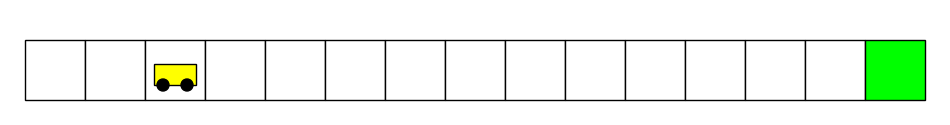

In [6]:
plot_grid_state(2,15,{})

In this simplified problem, the goal is to navigate the taxi on a 1-dimensional grid to the green square on the right end of the grid. We can perform two actions , "move left" and "move right". We incur a cost of 1 unit (or a reward of -1 unit) for every step we take prior to reaching the green square, and zero cost once we reach (and stay at) the green square.

At each time step we are told the ID of the grid cell that we are in, we select one of the two actions, and we are told the cost that we incurred (or reward we earned).

---

We will use the algorithm described below. In this algorithm we will maintain a table that contains an entry for each grid cell and action. Each entry will contain a grid cell ID, an action, and a numerical value. For example, several rows of this table could look as follows:

| Grid cell ID | Action | Value |
| :--- | :--- | :--- |
| 3 | Left | 7 |
| 3 | Right | 5 |
| 4 | Left | 6 |
| 4 | Right | 6 |

The steps of this algorithm are the following:

1. Initially start with an empty table.
2. Get the ID of the initial grid cell.
3. Add entries to the table for the initial grid cell ID and both actions. Initialize the numerical value to zero for these actions.
2. Repeat:
  - Get the ID of the current grid cell.
  - Select the action with the smallest value in the table for the current grid cell ID. If both values are equal, select an action at random.
  - Perform the selected action, observe the cost, and observe the ID of the next grid cell that we will visit.
  - If there is no entry in the table for the next grid cell ID, add entries to the table for this cell ID and both actions. Initialize the numerical value to zero for these actions.
  - Update the numerical value in the table for the current grid cell ID and action that we selected. **The new value will be the observed cost plus the smaller of the two values in the table for the next grid cell ID.**
  - Update the current grid cell ID with the next grid cell ID.

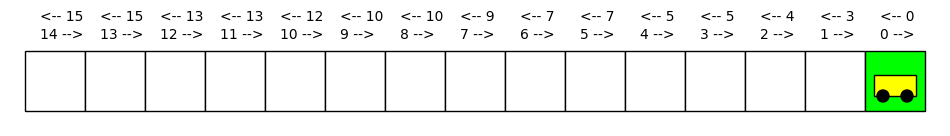

In [ ]:
# Choose a grid containing 15 cells
n = 15

# Initialize the state to the leftmost cell
s = 0

# Create an empty Q table
Q = {}

# Initialize the Q values for the initial state
Q[(s,0)] = 0
Q[(s,1)] = 0

# Loop over 15 episodes
# Each episode ends when the taxi reaches the green cell
episodes = 0
while episodes < 15:

  time.sleep(0.1)

  # Display the current state
  display.clear_output(wait=True)
  plot_grid_state(s,15,Q)

  #input()

  # If we reached the goal, re-initialize the state
  if s == n-1:
    time.sleep(1)
    episodes += 1
    s = 0

  # Select an action
  if Q[(s,0)] < Q[(s,1)]:
    a = 0
  elif Q[(s,0)] > Q[(s,1)]:
    a = 1
  else:
    a = random.randint(0,1)

  # Update our position
  if a == 0:
    s_next = max(0,s-1)
  else:
    s_next = min(s+1,n-1)

  # Add Q_next to the table if not yet in the table
  if (s_next,0) not in Q:
    Q[(s_next,0)] = 0
    Q[(s_next,1)] = 0

  # Update the Q table
  Qmin = min(Q[(s_next,0)], Q[(s_next,1)])
  Q[(s,a)] = 1 + Qmin

  # Set the current state to be the next observed state
  s = s_next

---

The *Q-learning* algorithm is conceptually very similar to the simple algorithm that we introduced above. We provide a general implementation of the Q-learning algirithm below. There are some small differences that we wont discuss in detail here (but cover in detail in the IK modules on reinforcement learning).

In [ ]:
class QLearner:
    """
    This class will allow us to specify a Gymnasium environment and apply
    tabular Q-learning on it.
    """

    def __init__(self, environment, g=0.98, a=0.05, e=0.05):
        # Initialize the following:
        # g: The discount factor used in our total discounted reward
        # a: The learning rate for Q-learning
        # e: The epsilon for epsilon-greedy action selection
        self.g = g
        self.a = a
        self.e = e
        self.env = gym.make(environment, render_mode="rgb_array")

        # Initialize the Q table
        # If the environment has a terminal state, set its Q value to zero
        self.Q = {}
        for i in range(self.env.action_space.n):
            self.Q[("done", i)] = 0.0

    def learn(self, n_steps):
        """
        This method is called to run Q-learning for n_steps time steps.
        """

        # Create local copies of Q-learning parameters
        g = self.g
        a = self.a
        e = self.e

        # Start a new episode and loop for n_steps
        done = True
        for k in range(n_steps):

            # Initiaize the new episode
            if done is True:
                obs = self.env.reset()[0]
                # If this state is not yet in the Q-table, add it and
                # initialize values to zero
                for i in range(self.env.action_space.n):
                    if (obs, i) not in self.Q:
                        self.Q[(obs, i)] = 0.0

            # Select an action with epsilon-greedy action selection
            if random.random() < e:
                action = self.env.action_space.sample()
            else:
                _, action = max(
                    (self.Q[(obs, i)],i) for i in range(self.env.action_space.n)
                )

            # Apply the selected action and observe the reward and next state
            obs_prev = obs
            obs, reward, done, info, other = self.env.step(action)
            # Indicate whether the episode reached the terminal state
            if done is True:
                obs = "done"

            # If the next state is not yet in the Q-table, add it and
            # initialize values to zero
            for i in range(self.env.action_space.n):
                if (obs, i) not in self.Q:
                    self.Q[(obs, i)] = 0.0

            # Update the Q value for the previous state and selected action
            maxQ, _ = max(
                (self.Q[(obs, i)],i) for i in range(self.env.action_space.n)
            )
            self.Q[(obs_prev, action)] = (1-a)*self.Q[(obs_prev, action)] + a*(reward + g*maxQ)

    def close(self):
        # Close the environment
        self.env.close()

We will now let the Q-learning algorithm learn how to solve the Taxi environment by interacting with the environment for 500K time steps.

In [ ]:
learner = QLearner("Taxi-v3")
learner.learn(500000)
learner.close()

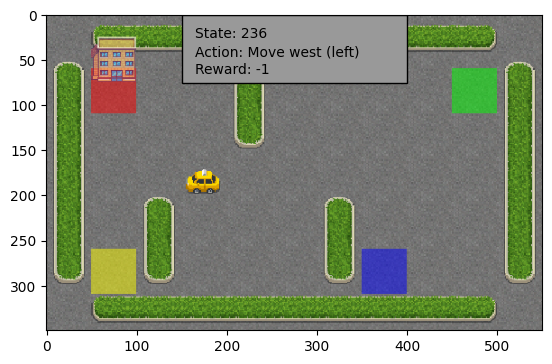

In [ ]:
action_desc = {
    0: "Move south (down)",
    1: "Move north (up)",
    2: "Move east (right)",
    3: "Move west (left)",
    4: "Pickup passenger",
    5: "Drop off passenger"
}

env = gym.make("Taxi-v3", render_mode="rgb_array")

obs = env.reset()[0]
plt.imshow(env.render())
plt.show()

for i in range(200):

    if (obs, 0) not in learner.Q:
        action = env.action_space.sample()
    else:
        _, action = max((learner.Q[(obs, i)],i) for i in range(env.action_space.n))

    obs, reward, done, info, other = env.step(action)

    display.clear_output(wait=True)
    plt.imshow(env.render())

    rect = matplotlib.patches.Rectangle(
        (150,0),
        250,
        75,
        facecolor="#999999",
        edgecolor="#000000"
    )
    ax = plt.gca()
    ax.add_patch(rect)
    plt.text(165,25,f"State: {obs}")
    plt.text(165,45,f"Action: {action_desc[action]}")
    plt.text(165,65,f"Reward: {reward}")

    plt.show()

    if done:
        obs = env.reset()[0]

    time.sleep(0.5)

env.close()

We can see that the learned policy now solves the taxi problem optimally in each run.

It is important to note that Q-learning knows nothing a-priori about the overall objective of this task. It simply is selecting actions and observing the resulting immediate rewards and next states. By building up the Q table, we encode a policy that is capable of performung the task.

---

We can apply the Q-learning algoithm that we implemented to an entirely different task and still learn a poilicy for performing that task skillfully.

Before finishing this demo, we will apply Q-learning to the Blackjack environment in Gymnasium. In this environment, a player plays a single hand of Blackjackagainst the dealer.

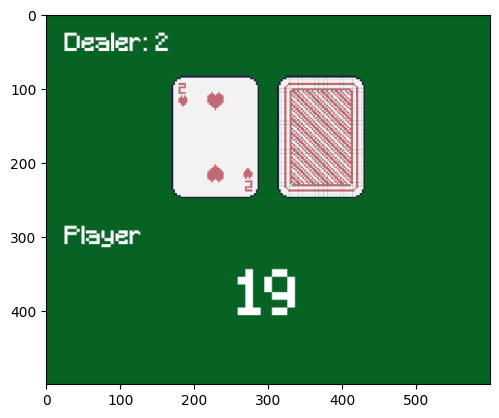

(19, 2, 0)


In [ ]:
env = gym.make("Blackjack-v1", render_mode="rgb_array")
obs = env.reset()[0]

plt.imshow(env.render())
plt.show()
print(obs)

env.close()

Just as with the Taxi environment, we will let Q-learning learn how to play Blackjack by playing for 500K turns.

In [ ]:
learner = QLearner("Blackjack-v1")
learner.learn(500000)
learner.close()

To evaluate the policy that we learned, we will play a fixed number of hands against the deealer and measure the fraction of hands that we win.

In [ ]:
def run_simulation(n_games, policy_func, **kwargs):
    """
    Here we provide a reusable function for evaluating Blackjack policies.
    For a given policy, this function will run n_games using the provided policy
    function and return the fraction of games won.
    """

    env = gym.make("Blackjack-v1", render_mode="rgb_array")

    wins = 0
    for i in range(n_games):

        obs = env.reset()[0]

        done = False
        while not done:
            action = policy_func(obs, **kwargs)
            obs, reward, done, truncated, info = env.step(action)

        if reward > 0:
            wins += 1

    env.close()

    return wins/n_games

#---

def Q_policy(state, Q):
    """
    This function implements a Blackjack policy from
    a given Q function.
    """

    if (state, 0) not in Q:
        return env.action_space.sample()
    elif Q[(state, 0)] > Q[(state, 1)]:
        return 0
    else:
        return 1

In [ ]:
run_simulation(50000, Q_policy, Q=learner.Q)

0.42316

Note that the known probability of winning a Blackjack hand if optimally played is 42.22% (we might see something higher here since there will be some estimation error from simulation). So, in this case it appears that Q-learning is able to learn an optimal (or very close to optimal) strategy for playing a single hand of Blackjack.